In [ ]:
#挂载网盘
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/GIS/forest_classification')

In [9]:
import matplotlib.pyplot as plt
from osgeo import gdal
import numpy as np
from skimage.feature import graycomatrix, graycoprops
# 老版本skimage
# from skimage.feature import greycomatrix as graycomatrix
# from skimage.feature import greycoprops as graycoprops
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
filename = r'shl.TIF'
dataset = gdal.Open(filename)
im_width = dataset.RasterXSize
im_height = dataset.RasterYSize
im_bands = dataset.RasterCount
extent = dataset.GetGeoTransform()
var = dataset.GetProjection()
for i in range(1, im_bands + 1):
    band = dataset.GetRasterBand(i)
    band_name = band.GetDescription()
    print(f'Band {i}: {band_name}')

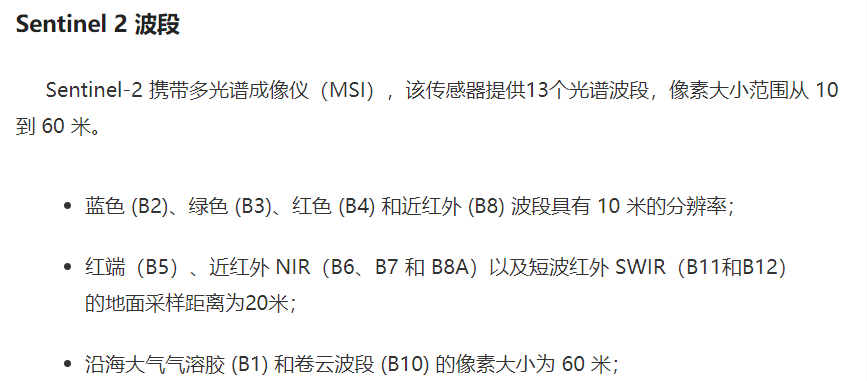

In [ ]:
red_band = dataset.GetRasterBand(3).ReadAsArray()/10100
green_band = dataset.GetRasterBand(2).ReadAsArray()/10100
blue_band = dataset.GetRasterBand(1).ReadAsArray()/10100
nir_band = dataset.GetRasterBand(4).ReadAsArray()/10100
flag_band = dataset.GetRasterBand(5).ReadAsArray()
flag_band[flag_band != 1] = 0

In [ ]:
rgb_image = np.dstack((red_band, green_band, blue_band))
rgb_image=rgb_image

plt.imshow(rgb_image)
plt.show()

In [ ]:
plt.imshow(flag_band[600:800,500:700], cmap='gray')

In [ ]:
#指数计算
ndvi = (nir_band - red_band) / (nir_band + red_band)
rvi = nir_band / red_band
dvi = nir_band - red_band
exg = 2 * nir_band - red_band - blue_band
vdvi = ( 2 * green_band - red_band - blue_band ) / ( 2 * green_band + red_band + blue_band )
ngbdi = ( green_band - blue_band ) / ( green_band + blue_band )
ngrdi = ( green_band - red_band ) / ( green_band + red_band )

In [ ]:
# 创建一个包含两行四列的子图网格
fig, axs = plt.subplots(2, 4, figsize=(12, 6))

# 调整子图之间的间距
plt.subplots_adjust(wspace=0.4, hspace=0.3)

im1 = axs[0, 0].imshow(ndvi, cmap='RdYlGn')
axs[0, 0].set_title('NDVI image')
plt.colorbar(im1, ax=axs[0, 0])

im2 = axs[0, 1].imshow(rvi, cmap='RdYlGn')
axs[0, 1].set_title('RVI image')
plt.colorbar(im2, ax=axs[0, 1])

im3 = axs[0, 2].imshow(dvi, cmap='RdYlGn')
axs[0, 2].set_title('DVI image')
plt.colorbar(im3, ax=axs[0, 2])

im4 = axs[0, 3].imshow(exg, cmap='RdYlGn')
axs[0, 3].set_title('ExG image')
plt.colorbar(im4, ax=axs[0, 3])

im5 = axs[1, 0].imshow(vdvi, cmap='RdYlGn')
axs[1, 0].set_title('VDVI image')
plt.colorbar(im5, ax=axs[1, 0])

im6 = axs[1, 1].imshow(ngbdi, cmap='RdYlGn')
axs[1, 1].set_title('NGBDI image')
plt.colorbar(im6, ax=axs[1, 1])

im7 = axs[1, 2].imshow(ngrdi, cmap='RdYlGn')
axs[1, 2].set_title('NGRDI image')
plt.colorbar(im7, ax=axs[1, 2])

# 隐藏最后一个子图
axs[1, 3].axis('off')

# 显示图形
plt.show()

In [ ]:
# 纹理计算
def texture(input,window_size=3,levels=255):

  input_2=(input*(levels+1)).astype(int)
  # 计算输入矩阵的行列数
  rows, cols = input.shape

  # 创建一个新的矩阵来存储纹理特征
  energy = np.zeros((rows, cols))
  correlation = np.zeros((rows, cols))
  contrast = np.zeros((rows, cols))
  homogeneity = np.zeros((rows, cols))

  # 遍历每个像素点
  for i in range(rows):
    if i%10==0:
      print(i/rows)
    for j in range(cols):
      # 确定当前窗口的范围
      row_start = max(0, i - window_size // 2)
      row_end = min(rows, i + window_size // 2 + 1)
      col_start = max(0, j - window_size // 2)
      col_end = min(cols, j + window_size // 2 + 1)

      # 提取当前窗口内的图像块
      image_block = input_2[row_start:row_end, col_start:col_end]

      # 计算当前窗口内图像块的灰度共生矩阵
      glcm = graycomatrix(image_block, distances=[1], angles=[0], levels=levels, symmetric=True, normed=True)

      # 提取能量（energy）作为纹理特征
      energy[i, j] = graycoprops(glcm, 'energy')[0, 0]
      correlation[i, j] = graycoprops(glcm, 'correlation')[0, 0]
      contrast[i, j] = graycoprops(glcm, 'contrast')[0, 0]
      homogeneity[i, j] = graycoprops(glcm, 'homogeneity')[0, 0]
  return energy,correlation,contrast,homogeneity

In [ ]:
# 4核并行计算纹理
# from multiprocessing.pool import ThreadPool as Pool

# PROCESSES=4
# with Pool(PROCESSES) as pool:
#     pramas=[(red_band, ),(green_band, ),(blue_band, ),(nir_band, )]
#     results=[pool.apply_async(texture,p) for p in pramas]

#     for r in results:
#         print('\t', r.get())

In [ ]:
files = glob.glob("texture/*")
print("包括以下纹理变量：")
i=0
for file in files:
  print(file[8:-4])
  vars()[file[8:-4]]=np.load(file)
  i=i+1
print("共计"+str(i)+"个纹理变量")

In [ ]:
# 创建一个包含4行4列的子图网格
fig, axs = plt.subplots(4, 4, figsize=(18, 12))
i=0
for file in files:
  temp=axs[int(i/4), i%4].imshow(vars()[file[8:-4]], cmap='gray')
  axs[int(i/4), i%4].set_title(file[8:-4])
  plt.colorbar(temp, ax=axs[int(i/4), i%4])
  i=i+1

In [ ]:
def pro(band):
  return band[600:800,500:700].flatten()
  #return band.flatten()

In [ ]:
feature_band = np.column_stack((pro(red_band), pro(green_band), pro(blue_band), pro(nir_band)))
feature_index = np.column_stack((pro(ndvi),pro(rvi),pro(dvi),pro(exg),pro(vdvi),pro(ngbdi),pro(ngrdi)))
feature_text = np.column_stack((pro(blue_contrast),pro(blue_correlation),pro(blue_energy),
pro(green_contrast),
pro(blue_homogeneity),
pro(green_correlation),
pro(green_energy),
pro(green_homogeneity),
pro(nir_contrast),
pro(nir_energy),
pro(nir_correlation),
pro(nir_homogeneity),
pro(red_contrast),
pro(red_energy),
pro(red_correlation),
pro(red_homogeneity)))
labels = pro(flag_band)
features=np.concatenate((feature_band,feature_index,feature_text),axis=1)
print('features共计'+str(features.shape[1])+'维')

In [ ]:
import pandas as pd
df_features = pd.DataFrame(features,columns=['red_band', 'green_band', 'blue_band', 'nir_band', 'ndvi', 'rvi', 'dvi', 'exg', 'vdvi',
                           'ngbdi', 'ngrdi', 'blue_contrast', 'blue_correlation', 'blue_energy', 'green_contrast',
                           'blue_homogeneity', 'green_correlation', 'green_energy', 'green_homogeneity',
                           'nir_contrast', 'nir_energy', 'nir_correlation', 'nir_homogeneity', 'red_contrast',
                           'red_energy', 'red_correlation', 'red_homogeneity'])
df_features.corr()

In [ ]:
df_index = pd.DataFrame(feature_index,columns=['ndvi', 'rvi', 'dvi', 'exg', 'vdvi','ngbdi', 'ngrdi'])
df_index.corr()

In [ ]:
feature_index = np.column_stack((pro(ndvi),pro(vdvi),pro(ngbdi),pro(ngrdi)))
features=np.concatenate((feature_band,feature_index,feature_text),axis=1)
print('features共计'+str(features.shape[1])+'维')

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# 计算特征与目标变量之间的互信息
selector = SelectKBest(score_func=mutual_info_regression, k=10)
selector.fit(features, labels)

# 获取选择的特征子集
selected_features = features[:, selector.get_support(indices=True)]
print('features共计'+str(selected_features.shape[1])+'维')

In [ ]:
from sklearn.model_selection import cross_val_score, KFold

# 创建SVM分类器
svm_classifier = SVC(kernel='rbf')

# 创建五折交叉验证对象
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# 执行五折交叉验证并计算准确率
accuracies = cross_val_score(svm_classifier, features, labels, cv=kfold)

# 计算最终准确率
final_accuracy = np.mean(accuracies)

# 打印输出最终准确率
print("最终准确率：", final_accuracy)